In [1]:
import pandas as pd
import requests
import urllib

from sqlalchemy import create_engine

# Custom upload with connection string
from engine_info import server_info

import warnings
warnings.filterwarnings('ignore')

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Creating a connection to MS SQL SERVER
params = urllib.parse.quote_plus(server_info)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
connection = engine.connect()

In [3]:
# Upload sales data
sales = pd.read_sql_table('Joburg_Fresh_produce_combined_cleaned', connection)

In [4]:
sales.head()

,rowid,date,commodity,container,unit_mass,product_combination,total_value_sold,total_qty_sold,total_kg_sold,average,highest_price,ave_per_kg,highest_price_per_kg
0,1,2020-08-20,AMADUMBE,20KG POCKET,20,"*,*,L,*,*",0.0,0,0.0,0.0,0.0,0.0,0.0
1,2,2020-08-20,APPLES,10 X 1KG ECONO PACK CARTON,10,"GOLDEN DELICIOUS,CL 1,*,*,*",100.0,1,10.0,100.0,100.0,10.0,10.0
2,3,2020-08-20,APPLES,10 X 1KG ECONO PACK CARTON,10,"ROYAL GALA,CL 1,*,*,*",0.0,0,0.0,0.0,0.0,0.0,0.0
3,4,2020-08-20,APPLES,11KG JUMBLE CARTON,11,"GOLDEN DELICIOUS,CL 2,L,*,*",0.0,0,0.0,0.0,0.0,0.0,0.0
4,5,2020-08-20,APPLES,11KG JUMBLE CARTON,11,"TOPRED,CL 2,L,*,*",0.0,0,0.0,0.0,0.0,0.0,0.0


In [5]:
len(sales)

55423

In [6]:
# Upload inventory data
inventory = pd.read_sql_table('Joburg_Fresh_produce_container_cleaned', connection)

In [7]:
inventory.head()

,rowid,date,commodity,container,qty_available,average_price_per_kg,MTD_total_value_sold_(R),total_value_sold_(R),Total_quatity_sold,MTD_Total_quatity_sold,Total_kg_sold,MTD_total_kg_sold
0,1,20 August 2020,AMADUMBE,20KG POCKET,2,0.00,39870.0,0.0,0.0,97.0,0.0,1940.0
1,2,20 August 2020,APPLES,10 X 1KG ECONO PACK CARTON,17,10.00,41932.0,100.0,1.0,547.0,10.0,5470.0
2,3,20 August 2020,APPLES,11KG JUMBLE CARTON,343,6.36,218914.0,1190.0,17.0,3170.0,187.0,34870.0
3,4,20 August 2020,APPLES,12 X 1KG ECONO PACK CARTON,3233,7.86,1454572.0,40738.0,432.0,17353.0,5184.0,208236.0
4,5,20 August 2020,APPLES,12.5KG M6 CARTON,12,0.00,16903.0,0.0,0.0,286.0,0.0,3575.0


For the purpose of this notebook, analysis will focus on potatoes.

In [8]:
inventory = inventory[inventory['commodity'] == 'POTATOES']
sales = sales[sales['commodity'] == 'POTATOES']

In [127]:
df = sales[sales['total_value_sold'] > 0]

In [128]:
df['container'].value_counts()

10KG POCKET    6144
7KG POCKET      553
2KG POCKET        6
3KG POCKET        6
4KG POCKET        2
Name: container, dtype: int64

In [129]:
# 10KG POCKET will be the focus of this notebook since it's the most active
len(df)

6711

In [156]:
price = df[['date', 'ave_per_kg']]

In [157]:
price.head()

,date,ave_per_kg
1532,2020-08-20,6.0
1533,2020-08-20,6.4
1535,2020-08-20,5.8
1536,2020-08-20,5.8
1538,2020-08-20,5.2


In [158]:
price = price.groupby('date')['ave_per_kg'].mean()

In [159]:
price = pd.DataFrame(price)

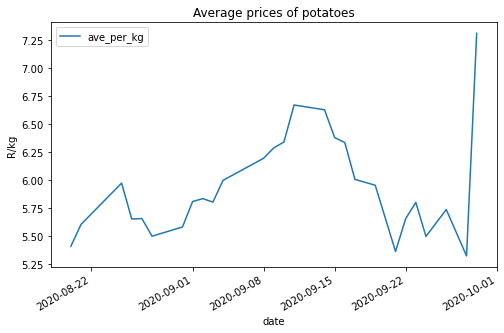

In [160]:
ax = price.plot(figsize=(8,5), title="Average prices of potatoes")
ax.set(ylabel='R/kg');

### Seasonal Decomposition

Time series decomposition involves the deconstruction of the time series data into the trend, seasonal and noise component.

In [161]:
price.index

DatetimeIndex(['2020-08-20', '2020-08-21', '2020-08-25', '2020-08-26',
               '2020-08-27', '2020-08-28', '2020-08-31', '2020-09-01',
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-08',
               '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-14',
               '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-19',
               '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
               '2020-09-26', '2020-09-28', '2020-09-29'],
              dtype='datetime64[ns]', name='date', freq=None)

In [162]:
price = price.asfreq('B', method='backfill')

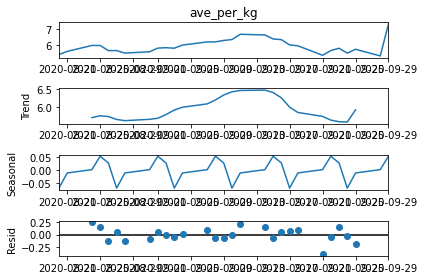

In [167]:
result = seasonal_decompose(price['ave_per_kg'], model='additive')  # model='mul' also works
result.plot();

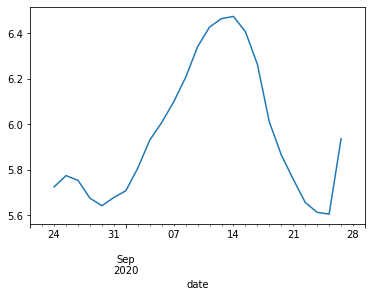

In [168]:
result.trend.plot();

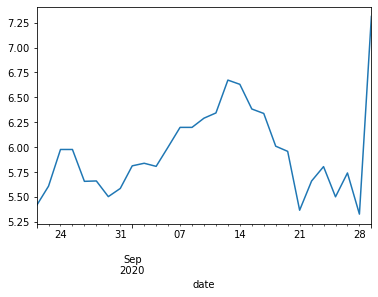

In [169]:
result.observed.plot();

In [171]:
result.trend.index

DatetimeIndex(['2020-08-20', '2020-08-21', '2020-08-24', '2020-08-25',
               '2020-08-26', '2020-08-27', '2020-08-28', '2020-08-31',
               '2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29'],
              dtype='datetime64[ns]', name='date', freq='B')

In [173]:
result.observed.values

array([5.41221429, 5.60708812, 5.97554264, 5.97554264, 5.65555556,
       5.65935849, 5.50191223, 5.58404858, 5.81126316, 5.83707407,
       5.80598746, 6.00014134, 6.19763566, 6.19763566, 6.29003774,
       6.34256705, 6.67264   , 6.63010471, 6.38232975, 6.33738983,
       6.00862676, 5.95665428, 5.36538776, 5.65880702, 5.80339552,
       5.5       , 5.73970874, 5.32621622, 7.31206009])